In [47]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from queue import PriorityQueue
import numpy as np
import torchtext
import tqdm
from torchnlp.metrics import get_moses_multi_bleu
from torchtext.data import Field, BucketIterator
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP
from io import BytesIO

import linecache
import sys
import os
import re
import random
import time
import operator
import collections
import json
from dotmap import DotMap
import ast
import astor

from base_transformer import TransformerModel, PositionalEncoding
from copy_gen_transformer import Transformer, TransformerDecoderLayer, TransformerDecoder
from ast_utils import *
import beam_search
from IPython.core.debugger import set_trace as tr
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
os.environ['CONFIG'] = "config_ast_model.json"

In [21]:
try:
    config_fp = os.environ['CONFIG']
except:
    config_fp = "config.json"
    
with open(config_fp) as config_file:
    config = json.loads(config_file.read())
    config = DotMap(config)

In [8]:
from datetime import datetime
def super_print(filename):
    '''filename is the file where output will be written'''
    def wrap(func):
        '''func is the function you are "overriding", i.e. wrapping'''
        def wrapped_func(*args,**kwargs):
            '''*args and **kwargs are the arguments supplied 
            to the overridden function'''
            #use with statement to open, write to, and close the file safely
            with open(filename,'a', encoding="utf-8") as outputfile:
                now = datetime.now()
                dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
                outputfile.write("[{}] ".format(dt_string))
                outputfile.write(" ".join(str(x) for x in args))
                outputfile.write("\n")
            #now original function executed with its arguments as normal
            return func(*args,**kwargs)
        return wrapped_func
    return wrap

print = super_print(config.log_file_name)(print)
print("env CONFIG:",config_fp)
print(config)

env CONFIG: config_ast_model.json
DotMap(max_seq_length=200, vocab_size=1600, log_file_name='logs_ast_model.txt', out_file_name='out_ast_model.txt', train_steps=1000000, train_learning_rate=0.005, src_file='./datasets/all.desc', tgt_file='./datasets/all.code', eval_interval=10000, log_interval=400, eval_beam_size=1, train_batch_size=32, eval_batch_size=32, model_layers=4, model_att_heads=8, model_embed_dim=512, model_dim_feedforward=1024, model_att_mask_noise=0.0)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.set_device(0) # choose GPU from nvidia-smi 
print("Using:", device)

Using: cpu


In [12]:
text = "Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application containing the migration.'))]))])"

def string_split(s):
#     return list(filter(lambda x: x != '' and x != "\n" and not x.isspace(), re.split('(_|\W)', s))) # this will chunk all code properly by plits strings with quotes
#     return list(filter(lambda x: x != '' and x != "\n" and not x.isspace(), re.split('(\\\'.*?\\\'|\\\".*?\\\"|_|\W)', s))) # this keeps the strings intact
    return list(filter(lambda x: x != '' and x != "\n" and not x.isspace(), re.split('(\\\'.*?\\\'|\\\".*?\\\"|\W)', s)))

print(string_split(text))

['Module', '(', 'body', '=', '[', 'Expr', '(', 'value', '=', 'Call', '(', 'func', '=', 'Attribute', '(', 'value', '=', 'Name', '(', 'id', '=', "'parser'", ',', 'ctx', '=', 'Load', '(', ')', ')', ',', 'attr', '=', "'add_argument'", ',', 'ctx', '=', 'Load', '(', ')', ')', ',', 'args', '=', '[', 'Str', '(', 's', '=', "'app_label'", ')', ']', ',', 'keywords', '=', '[', 'keyword', '(', 'arg', '=', "'help'", ',', 'value', '=', 'Str', '(', 's', '=', "'App label of the application containing the migration.'", ')', ')', ']', ')', ')', ']', ')']


In [13]:
def corpus_to_array(src_fp, tgt_fp):
    lines = []
    with open(src_fp, "r", encoding="utf-8") as src_file, open(tgt_fp, "r", encoding="utf-8") as tgt_file:
        for src, tgt in zip(src_file, tgt_file):
            lines.append((src, tgt))
    return lines

In [14]:
def filter_corpus(data, max_seq_length=200, tokenizer=string_split):
    return [(src, tgt) for src, tgt in data if len(string_split(src)) <= max_seq_length and len(string_split(tgt)) <= max_seq_length]

In [15]:
def samples_to_dataset(samples):
    """
    Args:
        samples: [(src_string),(tgt_string)]
        src/tgt_tokenizer: a func that takes a string and returns an array of strings
    """
    examples = []
    TEXT_FIELD = Field(sequential=True, use_vocab=False, init_token='<sos>',eos_token='<eos>')
    
    for sample in samples:
        src_string, tgt_string = sample
        examples.append(torchtext.data.Example.fromdict({"src":src_string, "tgt":tgt_string}, 
                                        fields={"src":("src",TEXT_FIELD), "tgt":("tgt",TEXT_FIELD)}))
        
    dataset = torchtext.data.Dataset(examples,fields={"src":src_field, "tgt":tgt_field})
    return dataset

In [22]:
data = corpus_to_array(config.src_file, config.tgt_file)
# data = corpus_to_array("datasets/all.desc", "datasets/all.code")
random.shuffle(data)
print("Max src length:", max([len(string_split(src)) for src, tgt in data]))
print("Max tgt length:", max([len(string_split(tgt)) for src, tgt in data]))

print("Full dataset size:", len(data))
max_seq_length=config.max_seq_length
data = filter_corpus(data, max_seq_length=max_seq_length, tokenizer=string_split)
print("Limited dataset size:", len(data))

Max src length: 557
Max tgt length: 527
Full dataset size: 18805
Limited dataset size: 18671


## Converting code to and from AST
Code is represented as a tree internamly when compiled and run. We take advantage of the inherent structure of this tree by compiling a line of code into the corresponding tree and representing that tree structure as a depth-first left-to-right sequence.

In [42]:
code_string = "parser . add_argument ( 'app_label' ,\n  help = 'App label of the application \\n containing the migration.' )"
tree = ast.parse(code_string)
print(ast.dump(tree))
print()
t = tree
print("Reduced tree:", ast.dump(t))
new_ast = dump_to_ast(ast.dump(t))

print()
print(ast.dump(new_ast))

print()
print(f"OG String    : {code_string}")
print(f"Code from AST: {astor.to_source(t)}")
foo = astor.to_source(new_ast).replace('\n','')
print(f"Rebuilt AST  : {' '.join(string_split(foo))}")

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application \n containing the migration.'))]))])

Reduced tree: Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application \n containing the migration.'))]))])

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='parser', ctx=Load()), attr='add_argument', ctx=Load()), args=[Str(s='app_label')], keywords=[keyword(arg='help', value=Str(s='App label of the application \\n containing the migration.'))]))])

OG String    : parser . add_argument ( 'app_label' ,
  help = 'App label of the application \n containing the migration.' )
Code from AST: parser.add_argument('app_label', help=
    """App label of the application 
 containing th

## ASTs Vs Code Tokens

[]

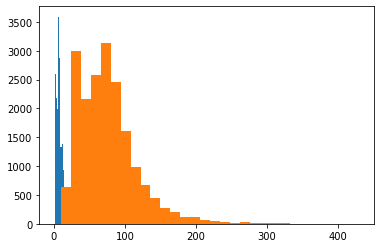

In [60]:
code_token_lengths = []
code_ast_lengths = []

for src, tgt in data:
    token_code_length = len(string_split(tgt))
    code_token_lengths.append(token_code_length)
    try:
        can_code = canonicalize_code(tgt)
        code_ast = ast.parse(can_code)
        ast_code_length = len(string_split(ast.dump(code_ast)))
        code_ast_lengths.append(ast_code_length)
    except:
        pass

plt.hist(code_token_lengths, bins=30)
plt.hist(code_ast_lengths, bins=30)
plt.plot()

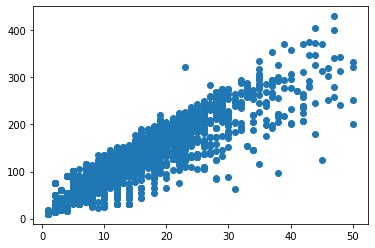

In [54]:
plt.scatter(code_token_lengths, code_ast_lengths)

In [57]:
len(code_token_lengths)

18671

In [58]:
len(code_ast_lengths)

18671